# Setup

In [463]:
import glob
from functools import partial

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchaudio
from tqdm.notebook import tqdm

from src.modules.training.datasets.to_2d.spec import Spec
from src.modules.training.datasets.to_2d.spec_normalize import SpecNormalize

In [464]:
def to_spec(arr):
    # convert numpy array of 5 sec audio to spectrogram
    cls = Spec(spec=partial(torchaudio.transforms.MelSpectrogram), output_shape=(224,224), scale=SpecNormalize(eps=1e-8), sequence_length=160000)

    # to tensor
    t = torch.tensor(arr)
    t = cls(t)
    return t.numpy()

In [465]:
# Show embeddings with t-SNE
def plot_tsne(src_embed,tgt_embed):
    from sklearn.manifold import TSNE

    tsne = TSNE(n_components=2, random_state=0)
    embed = np.concatenate([src_embed, tgt_embed])
    embed = tsne.fit_transform(embed)

    division = len(src_embed)

    # plot with plotly
    import plotly.express as px
    import pandas as pd

    df = pd.DataFrame(embed, columns=['x', 'y'])
    df['label'] = ['Source'] * division + ['Target'] * len(tgt_embed)
    df['Filename'] = list(src_files) + list(tgt_files)
    df['Size'] = 1
    fig = px.scatter(df, x='x', y='y', color='label', title='t-SNE embeddings', hover_data='Filename', size='Size', size_max=10)

    # set size
    fig.update_layout(
        autosize=False,
        width=1000,
        height=1000)
    fig.show()    

In [466]:
# train a classifier on the embeddings
def train_classifier(src_embed,tgt_embed, src_spec, tgt_spec, load_prev=False):
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score

    X = np.concatenate([src_embed, tgt_embed])
    y = np.array([0] * len(src_embed) + [1] * len(tgt_embed))

    X_train, X_test, y_train, y_test, _, spec_test = train_test_split(X,y,src_spec+tgt_spec, test_size=0.2, random_state=42)

    if load_prev:
        global clf
        print('Not retraining')
    else:
        clf = RandomForestClassifier(random_state=42)
        clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    pred_proba = clf.predict_proba(X_test)
    print(f'Accuracy score {accuracy_score(y_test, y_pred)}')
    print(f'Targetness of source {np.mean(pred_proba[y_test == 0][:,1]):0.3}')
    print(f'Targetness of target {np.mean(pred_proba[y_test == 1][:,1]):0.3}')

In [467]:
# Sample source and target data
seed = 42
sample_size = 1000
np.random.seed(seed)

In [468]:
def load_audio(path, length=32000*5):
    audio = librosa.load(path, sr=32000, dtype=np.float32,duration=5)[0]
    if length is None:
        return audio
    if len(audio) < length:
        audio = np.pad(audio, (0, length - len(audio)))
    return audio[:length]

In [469]:
# load the audio
src_files = glob.glob('../data/raw/2024/train_audio/*/*.ogg')
tgt_files = glob.glob('../data/raw/2024/unlabeled_soundscapes/*')
src_files = np.random.choice(src_files, sample_size, replace=False)
tgt_files = np.random.choice(tgt_files, sample_size, replace=False)
src_audio = [load_audio(file) for file in tqdm(src_files, desc='Loading source audio')]
tgt_audio = [load_audio(file) for file in tqdm(tgt_files, desc='Loading target audio')]

Loading source audio:   0%|          | 0/1000 [00:00<?, ?it/s]

Loading target audio:   0%|          | 0/1000 [00:00<?, ?it/s]

In [470]:
# load the metadata
import pandas as pd
meta = pd.read_csv('../data/raw/2024/train_metadata.csv')
short = ['/'.join(name.split('/')[-2:]) for name in src_files]
labels = [meta[meta['filename'] == name]['primary_label'].values[0] for name in short]

# Embeddings

In [471]:
from src.modules.training.models.pretrained_model import PretrainedModel

# model = PretrainedModel(model_path='../tm/97508247d5e4f164767e52f60b62b6c7_5_f0.pt') # convnext - ormix
# model = PretrainedModel(model_path='../tm/364804067b4e53dcdbc45836fc93a35c_0.pt') # eca-TF
# model = PretrainedModel(model_path='../tm/1b7e899a7102e98419652e54608cb11f_5_f0.pt') # eca-base-background
# model = PretrainedModel(model_path='../tm/f31acaf6a040242082d4f63c78d095ef_5_f0.pt') # convnext-norm
# model = PretrainedModel(model_path='../tm/ec2153138d52bee3e0812bc5d0047ac0_5_f0.pt',crop_head=182) # convnext-foundation
# model = PretrainedModel(model_path='../tm/7e2df7b4524ed298873788c5e2ac1565_5_f0.pt') # mdd glorious-pine
model = PretrainedModel(model_path='../tm/65d98dcf365ead579266f698a1f5a135_5_f0.pt',crop_head=182) # foundation eca
model.eval()

# model.model.model.reset_classifier(0)

def get_audio_embed(audio):
    with torch.no_grad():
        D = torch.tensor(to_spec(audio)).to(torch.device("cuda" if torch.cuda.is_available() else "cpu")).view(1,1, 224,224)
        return model(D).cpu().numpy()

def get_spec_embed(spec):
    with torch.no_grad():
        D = torch.tensor(spec).to(torch.device("cuda" if torch.cuda.is_available() else "cpu")).view(1,1,224,224)
        return model(D).cpu().numpy()

In [472]:
def aug1d(audio, is_target):
    if is_target:
        return audio
    return audio

src_spec = [to_spec(audio,) for audio in tqdm(src_audio, desc='Generating spectrograms')]
median_src = np.median(src_spec, axis=0)
prev = None
def aug2d(spec, is_target):
    # return clean(spec)
    if is_target:
        return spec
    # plt.imshow(spec, origin='lower')
    # plt.show()
    orig = np.copy(spec)

    # spec = spec * 0.15/0.18

    # # mixup with prev
    # global prev
    # if prev is not None:
    #     spec = 0.5*spec + 0.5*prev
    # prev = orig

    # replace background
    def gen_background(audioset, m):
        indices = np.arange(len(audioset))
        samples = np.random.choice(indices, m, replace=False)
        samples = [audioset[i] for i in samples]
        return np.median([to_spec(audio) for audio in samples], axis=0)

    total = (np.exp(spec) - np.exp(median_src)) + 1*np.exp(gen_background(tgt_audio,3))
    # spec = np.log(np.clip(total, 1e-8, a_max=np.inf), None)

    # minmax scale
    # spec = (spec - np.min(spec)) / (np.max(spec) - np.min(spec))

    # plt.imshow(spec, origin='lower')
    # plt.show()
    return spec

Generating spectrograms:   0%|          | 0/1000 [00:00<?, ?it/s]

In [473]:
src_spec = [aug2d(to_spec(aug1d(audio,False)),False) for audio in tqdm(src_audio, desc='Generating spectrograms')]
src_embed = [get_spec_embed(spec) for spec in tqdm(src_spec, desc='Generating embeddings')]
src_embed = np.stack(src_embed).squeeze(1)

tgt_spec = [aug2d(to_spec(aug1d(audio,True)),True) for audio in tqdm(tgt_audio, desc='Generating spectrograms')]
tgt_embed = [get_spec_embed(spec) for spec in tqdm(tgt_spec, desc='Generating embeddings')]
tgt_embed = np.stack(tgt_embed).squeeze(1)

Generating spectrograms:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating spectrograms:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/1000 [00:00<?, ?it/s]

In [474]:
plot_tsne(src_embed, tgt_embed)

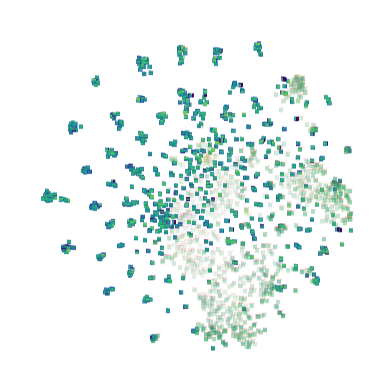

In [475]:
import cv2
from sklearn.manifold import TSNE
from PIL import Image

tsne = TSNE(n_components=2, random_state=0)
embed = np.concatenate([src_embed, tgt_embed])
embed = tsne.fit_transform(embed)
bird_names = sorted(meta['primary_label'].unique())

division = len(src_embed)

# make a canvas
# for every point, plot a small image of the spectogram, outline color of domain
resolution = 10000
img_size = 112
canvas = np.ones((resolution, resolution, 3), dtype=np.uint8) * 255
margin = 10
x_min = np.min(embed[:,0]) - margin
x_max = np.max(embed[:,0]) + margin
y_min = np.min(embed[:,1]) - margin
y_max = np.max(embed[:,1]) + margin

for i, (x, y) in enumerate(embed):
    x = int((x - x_min) / (x_max - x_min) * canvas.shape[0])
    y = int((y - y_min) / (y_max - y_min) * canvas.shape[1])
    img = np.stack([src_spec[i] if i < division else tgt_spec[i-division]], axis=-1)

    # apply colormap
    img = plt.cm.viridis(img)
    img = (img * 255).astype(np.uint8).squeeze(2)[:,:,:3]
    
    # set the  border to red or blue
    border = 5
    col = [0, 0, 255] if i < division else [255, 0, 0]
    img[-border:,:,:] = col
    img[:border,:,:] = col
    img[:,-border:,:] = col
    img[:,:border,:] = col
    
    # resize the image with PIL
    img = Image.fromarray(img)
    img = img.resize((img_size, img_size))
    img = np.array(img)        
       
    
    
    # write the label above the image
    if i < division:
        label = labels[i]
        canvas[y:y+img_size, x:x+img_size] = img
    else:
        # argmax of the prediction
        top = np.argmax(tgt_embed[i - division])
        topname = bird_names[top]
        prob = tgt_embed[i - division,top]
        label = f'{topname} - {prob:.3f}'
        # prob=1
        canvas[y:y+img_size, x:x+img_size] = prob * img + (1-prob) * canvas[y:y+img_size, x:x+img_size]
    cv2.putText(canvas, label, (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, col, 1, cv2.LINE_AA)

#write canvas to file directly
from PIL import Image
im = Image.fromarray(canvas)
im.save('canvas.png')

plt.imshow(canvas)
plt.axis('off')
plt.show() 


#1,3 -> 0.895
#3,3 -> 0.865#3,5 -> 0.925
#3,10 -> 0.945

In [476]:
train_classifier(src_embed, tgt_embed, src_spec, tgt_spec, load_prev=False)

Accuracy score 0.9175
Targetness of source 0.233
Targetness of target 0.781


Unlabeled soundscape sample:


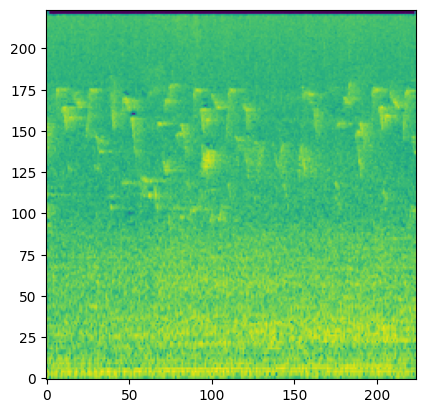

Predicted bird: niwpig1 with probability 0.31858882308006287


ValueError: Cannot take a larger sample than population when 'replace=False'

In [510]:
pred = tgt_embed
conf = np.max(pred, axis=1)

# sample based on confidence
sample = np.random.choice(np.arange(len(pred)), 1, p=conf/np.sum(conf))
sample = sample[0]
sample = tgt_audio[sample]

spec = to_spec(sample)
embed = get_spec_embed(spec)


def viz(spec, embed):
    def clean(spec):
        spec = spec - np.quantile(spec, 0.25, axis=1,keepdims=True)
        spec = spec - np.quantile(spec, 0.25, axis=0,keepdims=True)
    
        # normed = (medclean - np.min(medclean)) / (np.max(medclean) - np.min(medclean))
        return spec.astype(np.float32)
    
    print('Unlabeled soundscape sample:')
    plt.imshow((spec), origin='lower')
    plt.show()
    # plt.imshow(clean(spec), origin='lower', vmin=-0.5, vmax=0.5)
    # plt.show()
    
    predicted_bird = bird_names[np.argmax(embed)]
    predicted_prob = np.max(embed)
    print(f'Predicted bird: {predicted_bird} with probability {predicted_prob}')
    
    # find a source audio with the same bird using the labels from meta data
    same_bird = meta[meta['primary_label'] == predicted_bird]
    same_bird = same_bird.sample(6, random_state=42)
    same_bird_specs = [to_spec(load_audio(f'../data/raw/2024/train_audio/{row["filename"]}', length=32000*5)) for i, row in same_bird.iterrows()]
    print(f'Training data for {predicted_bird}:')
    fig, axs = plt.subplots(1, 6, figsize=(25, 10))
    for i, spec in enumerate(same_bird_specs):
        axs[i].imshow(spec, origin='lower')
        axs[i].axis('off')
    plt.show()
    # fig, axs = plt.subplots(1, 6, figsize=(25, 10))
    # for i, spec in enumerate(same_bird_specs):
    #     axs[i].imshow(clean(spec), origin='lower', vmin=-0.5, vmax=0.5)
    #     axs[i].axis('off')
    # # set clim for all
    # plt.show()
viz(spec, embed)